In [1]:
%matplotlib inline

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from lib.extraction import partition, enrich_song_features
from lib.prediction import predic_genre
from lib.plot import plot_genre_hist

from IPython.display import Audio

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.cluster import KMeans

In [3]:
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)

# Constructing a music genre classifier

## Introduction

In this project we are going to research the possibility to predict the genre of a given song by providing an audio file. The whole process includes features extraction, model training and classification. 

### The problem of song genre classification

The process of identification of song genre may seem trivial, but if we go deeper it may not be the case. When we talk about distinction between genres like heavy metal and classical music, it may seem pretty obvious. But one song may combine several genres. In contrast to the previous example, what we can say about symphonic metal ? It combines elements from two genres heavy metal and classical music. If we analyze certain parts of such song it can be fully classify as classical music. Also there are genres which highly overlap, for instance a modern country song may sound very close to a rock song. A disco and a pop song may be hard to distinguish.

## Dependencies

librosa  0.10.1
librosa  0.10.1

## Dataset

The main source of information used in this notebook is the famous [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) dataset, available in Kaggle. It contains 1000 song samples categorized in 10 genres: 
 * Pop
 * Country 
 * Metal 
 * Reggae 
 * Jazz 
 * Rock 
 * Blues 
 * Hip-hop 
 * Classical 
 * Disco
 
Each song sample is 30 seconds long. The dataset contains also some spectral images and two csv files with audio features extracted. In this research we won't use the provided sound features in the dataset, instead we are going to extract them ourself directly from the audio files.

## Installation

## Digital audio basics

As we all know from high school, the sound moves through a medium by alternately contracting and expanding parts of the medium it is traveling through. This compression and expansion create a minute pressure difference that we perceive as sound. In physics such distribution from place to place in a medium is called a wave and therefore the main characteristics of a certain sound is described by its sound wave.

### Sound as a waveform

The following diagram show some of the characteristics of the wave form:

![Sound as waveform](images/sound-as-waveform.png)

* **Amplitude** refers to the magnitude of compression and expansion experienced by the medium the sound wave is traveling through. This amplitude is perceived by our ears as loudness. High amplitude is equivalent to loud sounds.


* **Frequency / Pitch** in a sound wave refers to the rate of the vibration of the sound traveling through the air. In sound, the frequency is also known as Pitch. The frequency of the vibrating source of sound is calculated in cycles per second.  The time period is the time required for the wave to complete one cycle. The SI unit for frequency is hertz and its definition is $f = \frac{1}{T}$ where T refers to the time period of the wave.

![High pitch vs low pitch](images/high-vs-low-pitch.png)

### Audio signal

An audio signal is a representation of sound, typically using either a changing level of electrical voltage for analog signals, or a series of binary numbers for digital signals. Knowing that the three most important characteristics of sound are time, frequency it is not a surprise that the audio signal is three dimensional. The following diagram can help to see it in all its dimensions: 

![Audio signal dimensions](images/audio-signal-dimensions.png)

### Sampling

Sampling is the process of measuring the value of a continuous signal at fixed time steps. The sampled waveform is discrete, since it contains a finite number of signal values at uniform intervals.

<img src="images/singal-smapling.png" alt="Singal sampling" style="width:600px;"/>

The sampling rate (also called sampling frequency) is the number of samples taken in one second and is measured in hertz (Hz). The choice of sampling rate primarily determines the highest frequency that can be captured from the signal. This is also known as the Nyquist limit and is exactly half the sampling rate. The audible frequencies in human speech are below 8 kHz and therefore sampling speech at 16 kHz is sufficient. Using a higher sampling rate will not capture more information and merely leads to an increase in the computational cost of processing such files. 

In [4]:
audio_data = "data/metal/metal.00005.wav"
y, sampling_rate = librosa.load(audio_data)

The library we use for audio feature extraction is called **librosa** and has standard sampling rate of **22Khz**

In [5]:
Audio(data = y, rate = sampling_rate)

In [6]:
sampling_rate

22050

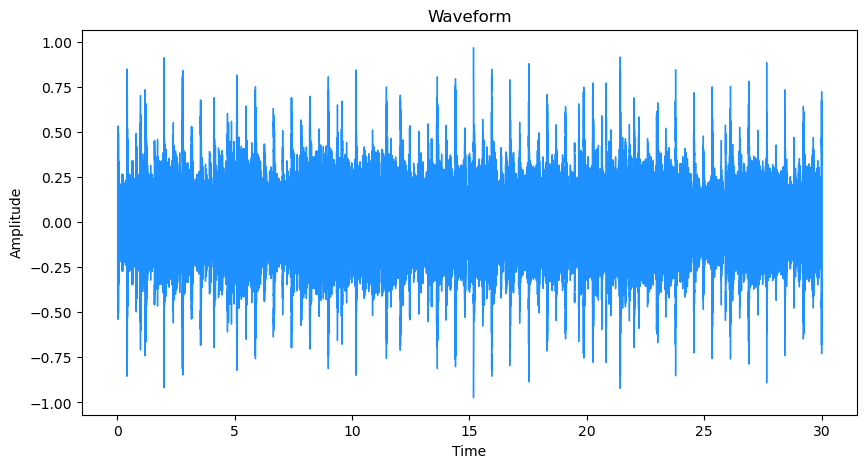

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Waveform")
librosa.display.waveshow(y, sr = sampling_rate, color="dodgerblue")
plt.ylabel("Amplitude")
plt.show()

### Sound spectrum

Every complex sound is a composite of multiple sound waves with different frequencies. A common way to display these frequencies is the sound spectrum. The spectrum is a representation of a sound in terms of the amount of vibration at each individual frequency. We can think of the sound spectrum as a sound recipe: take this amount of that frequency, add this amount of that frequency etc until you have put together the whole, complicated sound. It can be displayed on a spectrogram.

In [8]:
y = librosa.stft(y)

In [9]:
ydb = librosa.amplitude_to_db(abs(y))

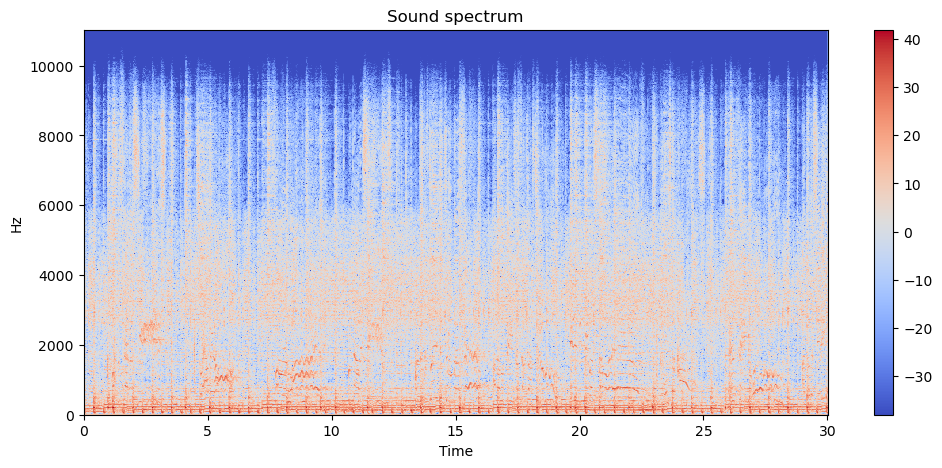

In [10]:
plt.figure(figsize=(12, 5))
plt.title("Sound spectrum")
librosa.display.specshow(ydb, sr = sampling_rate, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show()

## Audio features

The data provided by the audio samples cannot be directly understood by the machine learning models, so it needs to be converted to understandable format. This is why the feature extraction is an important step. We are going to use the **librosa** python library to extract the audio features directly from the sounds samples. Then we are going to use these features to train models.

Here is the list of audio features which we are going to use:

* Zero crossing rate
* Spectral centroid
* Rolloff Frequency
* Mel Frequency Cepstral Coefficients (MFCC)
* Flux
* RMSE
* Spectral Contrast
* Spectral Bandwidth
* Spectral Flatness

Every feature and the process of feature extraction is described in  [Audio Features Extraction](./AudioFeaturesExtraction.ipynb) notebook.

## Exploring the dataset

### How much information is encoded in just does half second

An audio file contains huge amount of information comparing to a tabular data. The default sampling rate of librosa is **22050**. Which means that 1 second of audio contains **22050** discrete values. This can be observed easily. Lets plot the waveform for just a half of second of audio.

In [11]:
audio_data = "data/metal/metal.00005.wav"
y, sampling_rate = librosa.load(audio_data)

The length of 30 seconds audio sample is:

In [12]:
len(y)

661504

And now for half a second:

In [13]:
one_second = int(len(y) / 60)

In [14]:
y = y[0:one_second]

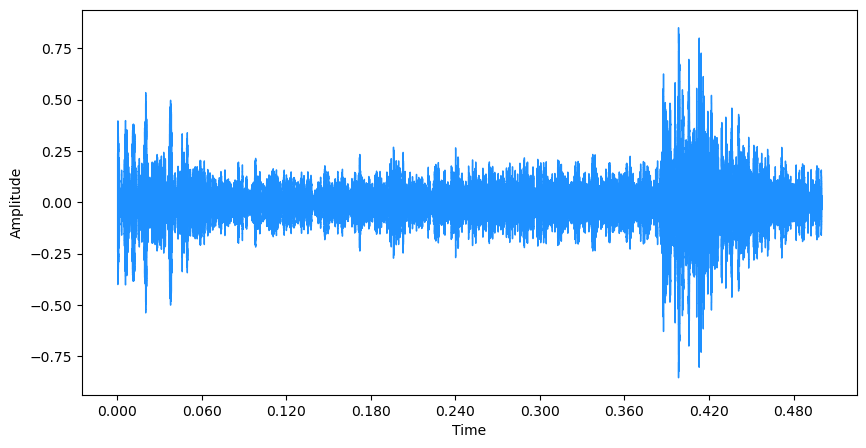

In [15]:
plt.figure(figsize=(10, 5))
librosa.display.waveshow(y, sr = sampling_rate, color="dodgerblue")
plt.ylabel("Amplitude")
plt.show()

### Exploring the 30 seconds feature dataset

The songs samples in the [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) data set have length around 30 seconds. The extracted audio features contain min, max, mean, std, kurtosis and skew for every feature, which means that they are generalized over the whole input sample. Our initial strategy was to use the features extracted on the whole song sample we are provided with. It failed miserably because we have very small dataset.   

Lets explore this dataset:

In [16]:
songs = pd.read_csv("data/30_seconds_song_features.csv", low_memory=False)

In [17]:
songs

,zero_crossings_max,zero_crossings_min,zero_crossings_mean,zero_crossings_std,zero_crossings_kurtosis,zero_crossings_skew,centroid_max,centroid_min,centroid_mean,centroid_std,...,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre,file
0,0.752441,0.009766,0.144590,0.082585,9.540830,2.444111,7412.694108,1022.153015,3302.342044,893.866324,...,0.002264,21.563793,-23.538502,0.544136,7.403120,0.046500,-0.178789,117.453835,pop,pop.00024.wav
1,0.682129,0.011719,0.145827,0.108406,4.443655,1.947596,8040.036703,965.917225,2940.712732,1290.550571,...,0.053169,24.365047,-36.742607,-3.502535,8.535687,0.208987,-0.296028,99.384014,pop,pop.00058.wav
2,0.676270,0.018066,0.121279,0.089060,13.139049,3.260256,7513.716630,698.671998,2885.707646,988.136171,...,-0.240175,15.289233,-25.785180,-2.685357,6.333065,0.292852,-0.318905,161.499023,pop,pop.00008.wav
3,0.674316,0.003906,0.072507,0.074976,27.751176,4.805041,7523.680993,753.456471,1996.214762,978.055235,...,-0.073378,19.543030,-21.030888,-3.200028,5.797513,0.272921,0.051250,112.347147,pop,pop.00079.wav
4,0.671387,0.007812,0.142882,0.092810,2.602808,1.200830,7387.704967,595.120877,3126.086716,972.528281,...,0.632891,27.504042,-34.374443,-1.224632,8.387035,0.740220,-0.310612,103.359375,pop,pop.00078.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,0.429688,0.013184,0.154277,0.057703,2.119194,0.693468,5543.291625,1080.617808,2615.398850,585.437364,...,0.149398,37.331573,-31.768559,-7.373089,7.614615,0.856139,0.197147,99.384014,disco,disco.00048.wav
923,0.484863,0.058594,0.169988,0.051547,7.649568,2.056028,5212.853055,1473.049674,2592.271461,506.006198,...,-0.172077,13.354691,-36.042137,-12.028731,7.713210,0.087752,0.043065,123.046875,disco,disco.00052.wav
924,0.454590,0.014648,0.131841,0.062179,2.818245,1.299597,5822.532186,851.802097,2739.275175,699.574463,...,-0.494983,19.650800,-27.985397,0.808960,7.346756,0.232449,-0.351014,112.347147,disco,disco.00012.wav
925,0.419434,0.035645,0.138467,0.050052,4.400630,1.600552,6249.889744,1345.064509,3075.215095,620.704023,...,-0.080007,16.779268,-32.086174,-2.831664,7.741563,0.192752,-0.446212,103.359375,disco,disco.00029.wav


As it is visible we have multiple features but very few rows. This proved to be a problem. More details are available at [Music Genre Classifier Model Selection](./ModelSelection.ipynb) notebook, but in short a Logistic Regression and SVM Classifier returned very close results which was a signal that some feature engineering is required.

In [18]:
songs["genre"].unique()

array(['pop', 'country', 'metal', 'reggae', 'jazz', 'rock', 'blues',
       'hiphop', 'classical', 'disco'], dtype=object)

In [19]:
songs.dtypes

zero_crossings_max         float64
zero_crossings_min         float64
zero_crossings_mean        float64
zero_crossings_std         float64
zero_crossings_kurtosis    float64
                            ...   
mfcc_12_kurtosis           float64
mfcc_12_skew               float64
tempo                      float64
genre                       object
file                        object
Length: 135, dtype: object

### Exploring distribution of some of the fields

To gain basic understanding of our dataset we are going to analyze the distribution of some of the fields in order to experiment with the correct scaler.

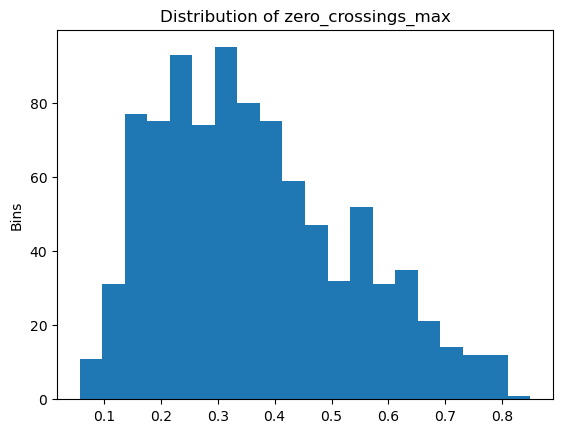

In [20]:
plt.title("Distribution of zero_crossings_max")
plt.hist(songs["zero_crossings_max"], bins  = 20)
plt.ylabel("Number of records")
plt.ylabel("Bins")
plt.show()

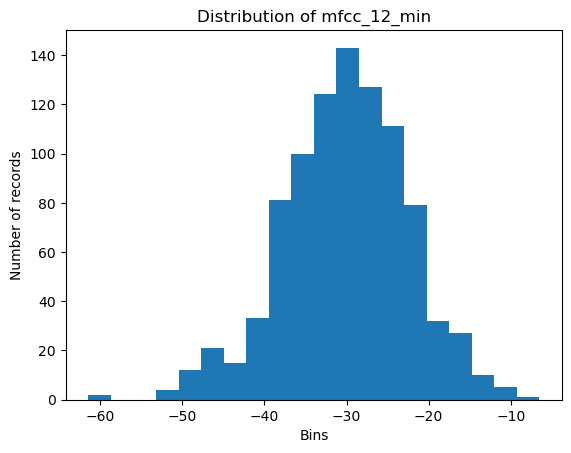

In [21]:
plt.title("Distribution of mfcc_12_min")
plt.hist(songs["mfcc_12_min"], bins  = 20)
plt.ylabel("Number of records")
plt.xlabel("Bins")
plt.show()

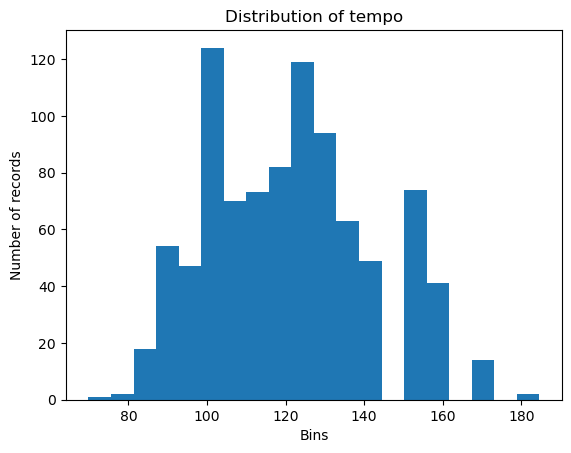

In [22]:
plt.title("Distribution of tempo")
plt.hist(songs["tempo"],  bins  = 20)
plt.ylabel("Number of records")
plt.xlabel("Bins")
plt.show()

This very basic analysis shows a potential centric tendence in the observed features. Also the fact that we use going to experiment with PCA, SVM and KNN algorithms, makes the **Standard scaler** a good candidate.

## Model Selection

### Supervised learning

We are going to apply several supervised learning algorithms and tune them in order to select a good one for our task of music genre classification. We are going to try the following classification algorithms:

* Logistic Regression
* Random Forest
* SMV

For each algorithm we have different notebook. We apply grid search to tune the hyper-parameters and the results are saved in **mlflow**.

Initially we tried our algorithms with the 30 seconds sample. The detailed experiments and parameter tunings are available in the "model_selection" folder. There is also the mlruns folder.

#### Classification result for sound features extracted from 30 second seamples

* Logistic Regression

Train score: **0.9679054054054054**\
Validation score: **0.7986577181208053**

* Random Forest

Train score: **1.0**\
Validation score: **0.7544910179640718**

* SVM Classifier

Train score: **1.0**\
Validation score: **0.785234899328859**

Following this results, we can easilly observe that the Logistic Regression after hyper parameter tunning
has the best accuracy on the validation set. Also the two more powerflull algorythms - Random Forrest and the SVM have train score of 1.0. We can form the following hypothesys: 
* It is very likelly that the Random Forest and the SVM overfit on the training set
* The fact that the weaker algorythm has simillar or better performance than a stornger one, can mean that we have reached the limit of this dataset
* We may apply some feature engineering to improve the performance

#### Back to the dataset

Thirty second on audio data at the standard sampling rate of 22Khz actually produce 661504 of records. This is 
vast amaunt of information. Like always the devils is in the details. As it  is mentioned in the [Audio Features Extraction](./AudioFeaturesExtraction.ipynb) notebook, during the feature extraction we apply aggragate statistical functions.

```python
    features["zero_crossings"] = librosa.feature.zero_crossing_rate(y).ravel()
    ...
    def aggregate_features(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    features = aggregate_features(features)
```

Imagine we have 30 seconds audio sample. When we extract the **zero_crossings** audio feature, we are going to receive an array of the calculated **zero_crossings** for every **y**. Then when applying the aggregate_features function we are going to have 6 features in our data set. This is convinient because transforms a single 30 seconds audio sample to single observation with 135 features. But as our initial anlysys shows - this may lead to very big information loss.

#### Feature engineering

In the case of our problem, the term **feaure engineering** probably is not the correct one. What we acutally need is **observation engineering**, but the idea is simple. Instaed of using the whole sample of 30 seconds we can split is to smaller chunks. We can label these chuncks, after all 3 seconds of disco song is still disco. The result of 30 seconds of audio sample, splitted to 5 will be 5 audio sampless of 6 seconds each. This means that now one sample could produce 5 observations insated of 1.

We have decied to experiment with two sample sizes 6 seconds and 3 seconds. After application of this tactic a two new datasets were created: **6_seconds_song_features.csv** and **3_seconds_song_features.csv**. They are similar to our initial set but with more observations.

In [23]:
songs = pd.read_csv("data/6_seconds_song_features.csv", low_memory=False)

In [24]:
songs.shape

(4635, 135)

In [25]:
songs = pd.read_csv("data/6_seconds_song_features.csv", low_memory=False)

In [26]:
songs.shape

(4635, 135)

#### Classification result for sound features extracted from 6 second seamples

* Logistic Regression

Train score: **0.8975050573162509**\
Validation score: **0.8126684636118598**

* Random Forest

Train score: **0.9991007194244604**\
Validation score: **0.8479041916167664**

* SVM Classifier

Train score: **0.9986513823331086**\
Validation score: **0.9043126684636119**

With more observations the stronger algorythms like Random Forest and SVM start to give better results. It seems that 
out hypothesys may be correct. We are going to continue with even bigger dataset.

#### Classification result for sound features extracted from 3 second seamples

* Logistic Regression

Train score: **0.8639581928523263**\
Validation score: **0.8032345013477089**

* Random Forest

Train score: **0.9994006592747977**\
Validation score: **0.8585979628520072**

* SVC With RBF kernel [**Best Model**]

Train score: **0.9993256911665542**\
Validation score: **0.9097035040431267**\
Test score: **0.9093851132686084**

## Reading the dataset

In [27]:
songs = pd.read_csv("data/3_seconds_song_features.csv")

In [28]:
song_features = songs.drop(columns=["genre" , "file"], axis=1)

In [29]:
song_genres = songs["genre"]

## How close is one genre to another ?

As it was mentioned in the introduction section, some genres are very close to each other. Sometimes it is not very easy to distinguish if a song is jazz or rock. Same could be true for country and rock. Sometimes it is hard to say if a song is pop or disco. And all this is problematic for the listener, we can imagine how confusing this could be for a model itself.

### K-Means Clustering

We are going to try to research the problem with music genre commonality, by applying k-means clustering. For reproducibility we use fixed random state.

In [30]:
random_state = 1234

In [31]:
clustering_model = Pipeline([
    ("sndard_scaler", StandardScaler()),
    ("k_means", KMeans(n_clusters=10, n_init="auto", random_state=random_state))
])

In [32]:
clustering_model.fit(song_features)

Pipeline(steps=[('sndard_scaler', StandardScaler()),
                ('k_means',
                 KMeans(n_clusters=10, n_init='auto', random_state=1234))])

In [33]:
clusters = pd.DataFrame(clustering_model["k_means"].labels_, columns=["cluster"])

In [34]:
clusters_genres = pd.concat([clusters, song_genres], axis=1)

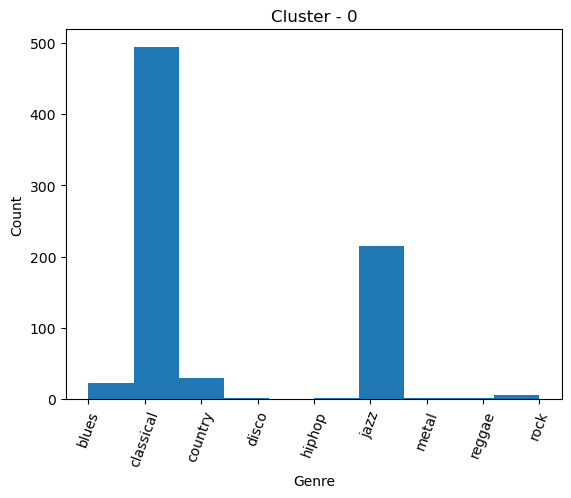

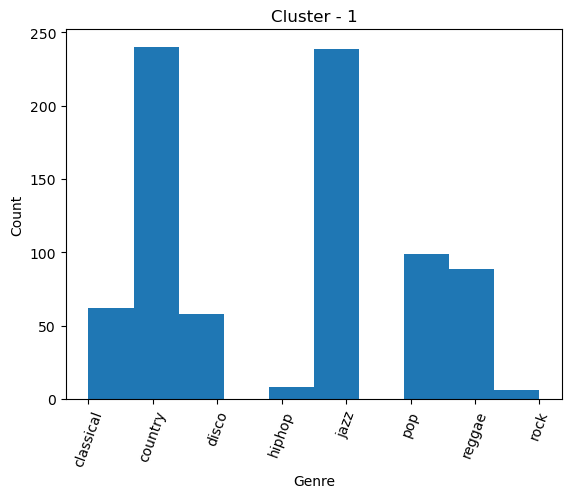

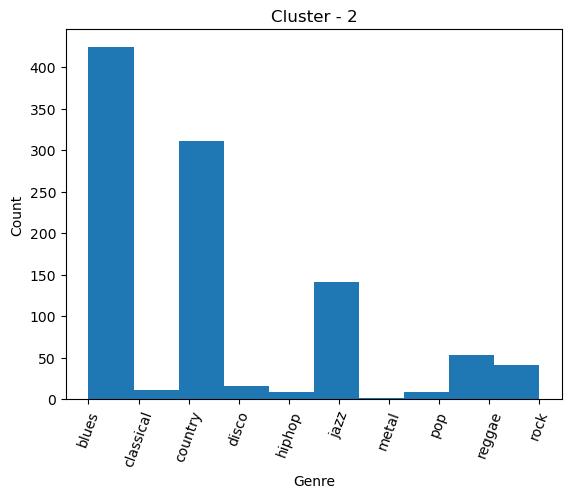

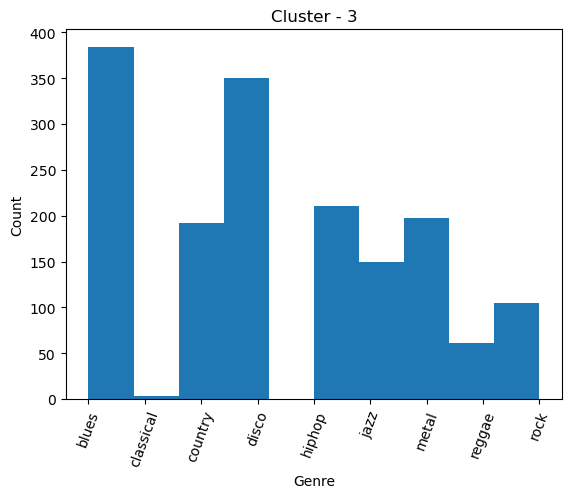

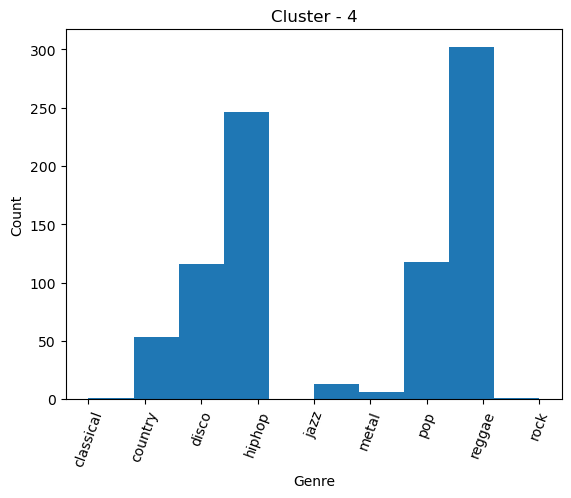

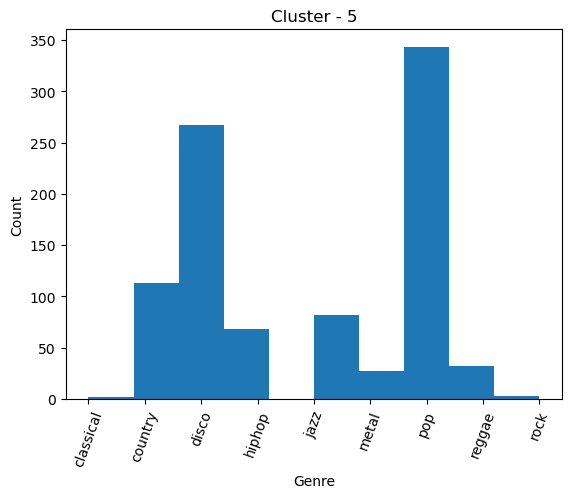

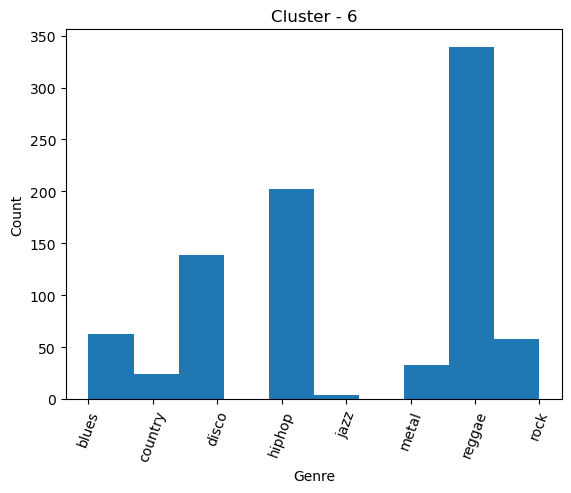

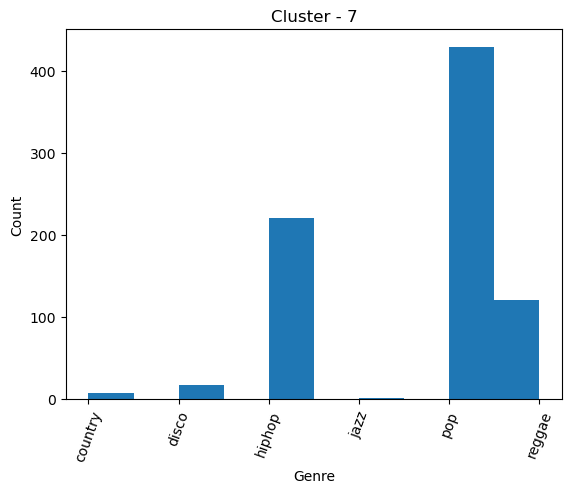

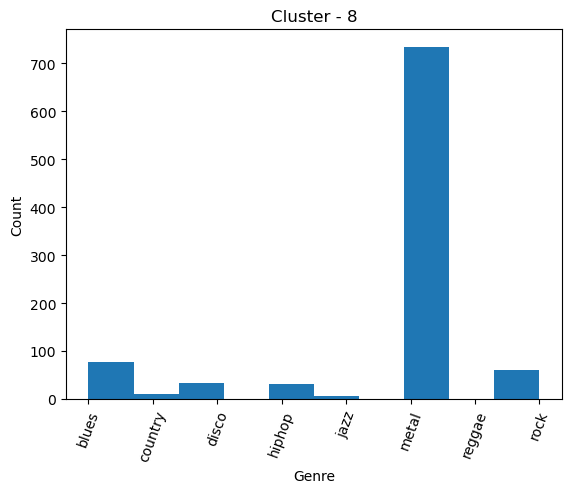

In [35]:
for i in range(0,9):
    cluster_genres = clusters_genres[clusters_genres["cluster"] == i]
    plot_genre_hist(cluster_genres["genre"], f"Cluster - {i}".format(i))

Based on our K-Means clustering it seems that only heavy metal and classical music are well separated from the other genres. Also there is no cluster dominated by the rock genre which means it will be hard to be distinguished fro other genres. This is confirmed with the fact that the rock genre has the lowest accuracy an f1-score from all genres. Cluster 3 demonstrates that no matter it is dominated by blues and disco, it contains a set of samples which genre is hard to be determined, this are  probably sample which can be replaced. Also the whole rock sample of songs could be replaced. The other clusters shown some close proximity between:

* disco  and pop
* blues and country

Such a proximity is understandable because these genres are relatively close. It is sometimes hard to say if a given slow song is country or blues. The commonality between:

* classical music and jazz

Such commonality could be interpreted by the fact that classical instruments like piano, trumpet and contrabass are used to play jazz music.

The most surprising commonality for me is in Cluster 1, between:

* country and jazz

And it is hard to explain. My assumption is that, the country sample contains some slow instrumentals including piano tracks. But from a human perspective these two samples are quite distinctive. And I think they have good quality, because the jazz section contains classical jazz which is not so influenced by other genres like the modern jazz. The country audio samples contain several slow songs, some of include piano tracks. Some of these lack the typical guitar and harmonics. This is possible explanation but it is just a hypothesis. 

## Predicting song genre

We have trained our models using sound samples with length of 3 seconds. How we are going to predict a genre for 
a sample with length of 30 seconds. And what about a full song with length 3 min ?

We are going to split a song with a $length > min(sample\ length)$ to multiple short samples equal to the $min\  sample\ length$. Than we can classify each split, and finally we can use the majority of the predicted genres for identifying the genre of the full song.

### Training our best model

In [89]:
genre_encoder = LabelEncoder()

In [90]:
encoded_song_genres = genre_encoder.fit_transform(song_genres)

In [91]:
model = Pipeline([
    ("sndard_scaler", StandardScaler()),
    ("reduce_dimension", None),
    ("svm", SVC())
])

During the model selection we have found that the best model is SVM classifier with the following parameters:

{'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}

In [39]:
model.set_params(svm__C = 100, svm__gamma = 0.01, svm__kernel = "rbf")

Pipeline(steps=[('sndard_scaler', StandardScaler()), ('reduce_dimension', None),
                ('svm', SVC(C=100, gamma=0.01))])

In [40]:
model.fit(song_features, encoded_song_genres)

Pipeline(steps=[('sndard_scaler', StandardScaler()), ('reduce_dimension', None),
                ('svm', SVC(C=100, gamma=0.01))])

We have selected the best performing model, and we have trained it. Now it is time for real testing.

### Predicting genre of youtube songs

In the lib forder there is a script called - youtube_download.py. I can be called:
```python
python youtube_download.py
```

It expects a "data" folder available in the project root and "data/youtube" sub directory. It will download and encode in .wav the following songs:

```python
songs = [
    {
        "name" : "Eminem - Without Me",
        "url" : "https://www.youtube.com/watch?v=YVkUvmDQ3HY",
        "genre" : "Hip-hop"
    },
        {
        "name" : "Busta Rhymes - Break Ya Neck",
        "url" : "https://www.youtube.com/watch?v=W7FfCJb8JZQ",
        "genre" : "Hip-hop"
    },        
    {
        "name" : "Chopin - Nocturne Op. 72 No. 1 in E minor",
        "url" : "https://www.youtube.com/watch?v=i5XgcakgWf4",
        "genre" : "Classical"
    },
    {
        "name" : "Carl Orff - O Fortuna ~ Carmina Burana",
        "url" : "https://www.youtube.com/watch?v=GXFSK0ogeg4",
        "genre" : "Classical"
    },
    {
        "name" : "Josh Turner - Your Man",
        "url" : "https://www.youtube.com/watch?v=nADTbWQof7Y",
        "genre" : "Country"
    },
    {
        "name" : "Just a closer walk with thee - Patsy Cline And Willie Nelson",
        "url" : "https://www.youtube.com/watch?v=OOKaircCiGI",
        "genre" : "Country"
    },
    {
        "name" : "Bob Marley & The Wailers - Buffalo Soldier",
        "url" : "https://www.youtube.com/watch?v=uMUQMSXLlHM",
        "genre" : "Reggae"
    },
    {
        "name" : "Dave Brubeck - Take Five",
        "url" : "https://www.youtube.com/watch?v=PHdU5sHigYQ",
        "genre" : "Jazz"
    },
    {
        "name" : "Dua Lipa - New Rules",
        "url" : "https://www.youtube.com/watch?v=k2qgadSvNyU",
        "genre" : "Pop"
    },
    {
        "name" : "Christina Aguilera - Genie In A Bottle",
        "url" : "https://www.youtube.com/watch?v=kIDWgqDBNXA",
        "genre" : "Pop"
    },
    {
        "name" : "Sandra - Maria Magdalena",
        "url" : "https://www.youtube.com/watch?v=4jjzu1Z2RZc",
        "genre" : "Disco"
    },
    {
        "name" : "Bee Gees - Stayin' Alive",
        "url" : "https://www.youtube.com/watch?v=fNFzfwLM72c",
        "genre" : "Disco"
    },
    {
        "name" : "Still Got The Blues",
        "url" : "https://www.youtube.com/watch?v=0dWDM0k3OE8",
        "genre" : "Blues"
    },
    {
        "name" : "B.B. King - The Thrill Is Gone",
        "url" : "https://www.youtube.com/watch?v=oica5jG7FpU",
        "genre" : "Blues"
    },
    {
        "name" : "Lynyrd Skynyrd - Sweet Home Alabama",
        "url" : "https://www.youtube.com/watch?v=-p8GXZcdrIk",
        "genre" : "Rock"
    },
    {
        "name" : "Bill Haley & His Comets - Rock Around The Clock",
        "url" : "https://www.youtube.com/watch?v=ZgdufzXvjqw",
        "genre" : "Rock"
    },
    {
        "name" : "Metallica - Seek & Destroy",
        "url" : "https://www.youtube.com/watch?v=FLTchCiC0T0",
        "genre" : "Metal"
    },
    {
        "name" : "Iron Maiden - Aces High",
        "url" : "https://www.youtube.com/watch?v=CfPKxm9O04Y",
        "genre" : "Metal"
    },
]
```

### Hip-hop song

In [41]:
audio_data = "data/youtube/Busta Rhymes - Break Ya Neck (Official Video).wav"
y, sampling_rate = librosa.load(audio_data)

In [42]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

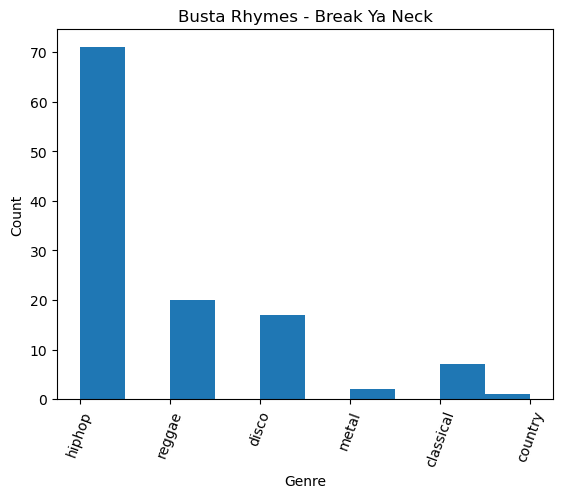

In [43]:
plot_genre_hist(predicted, "Busta Rhymes - Break Ya Neck",y_label="Parition Count")

In [44]:
audio_data = "data/youtube/Eminem - Without Me (Official Music Video).wav"
y, sampling_rate = librosa.load(audio_data)

In [45]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

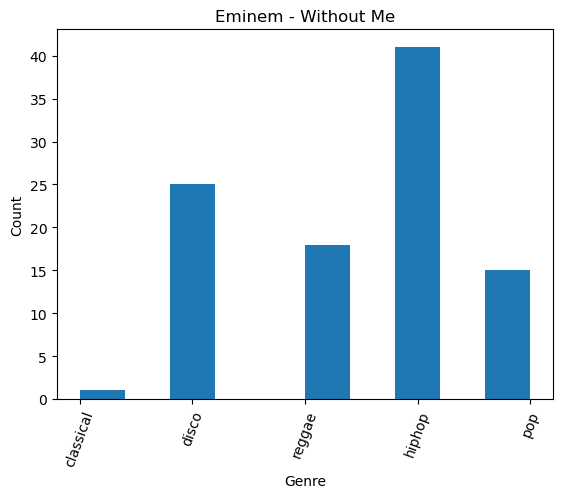

In [46]:
plot_genre_hist(predicted, "Eminem - Without Me",y_label="Parition Count")

### Classical music

In [47]:
audio_data = "data/youtube/Chopin - Nocturne Op. 72 No. 1 in E minor.wav"
y, sampling_rate = librosa.load(audio_data)

In [48]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

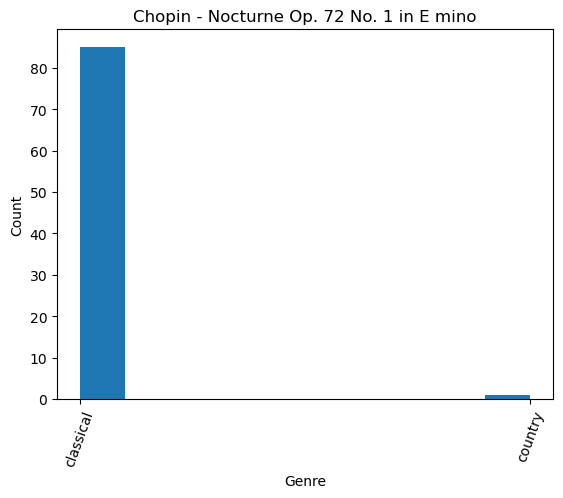

In [49]:
plot_genre_hist(predicted, "Chopin - Nocturne Op. 72 No. 1 in E mino",y_label="Parition Count")

In [50]:
audio_data = "data/youtube/Carl Orff - O Fortuna ~ Carmina Burana.wav"
y, sampling_rate = librosa.load(audio_data)

In [51]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

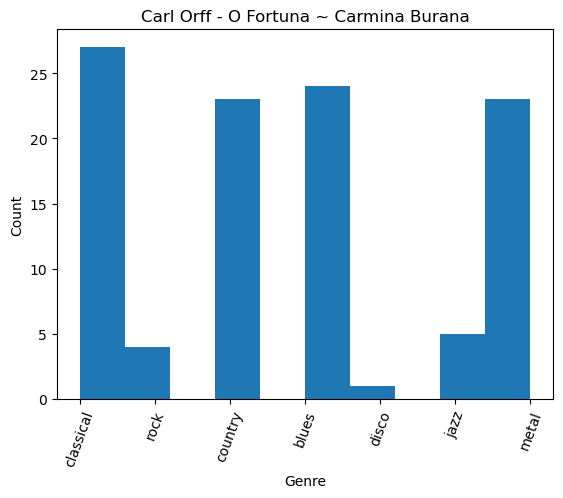

In [52]:
plot_genre_hist(predicted, "Carl Orff - O Fortuna ~ Carmina Burana",y_label="Parition Count")

Carl Orff's "Carmina Burana" is definitely not country, blues or especially metal. It should be classified as classical music. A possible explanation is the dataset contains very few samples of operas and mostly instrumental. In contrast "Carmina Burana" uses large choral ensembles which may confuse the model.

### Country music

In [53]:
audio_data = "data/youtube/Josh Turner - Your Man (Official Music Video).wav"
y, sampling_rate = librosa.load(audio_data)

In [54]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

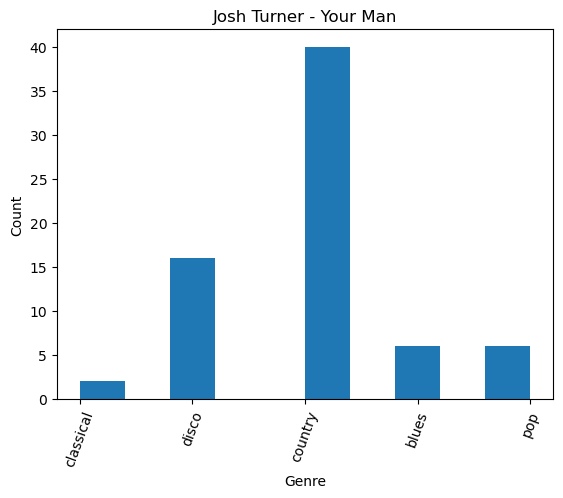

In [55]:
plot_genre_hist(predicted, "Josh Turner - Your Man",y_label="Parition Count")

In [56]:
audio_data = "data/youtube/Just a closer walk with thee - Patsy Cline And Willie Nelson.wav"
y, sampling_rate = librosa.load(audio_data)

In [57]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

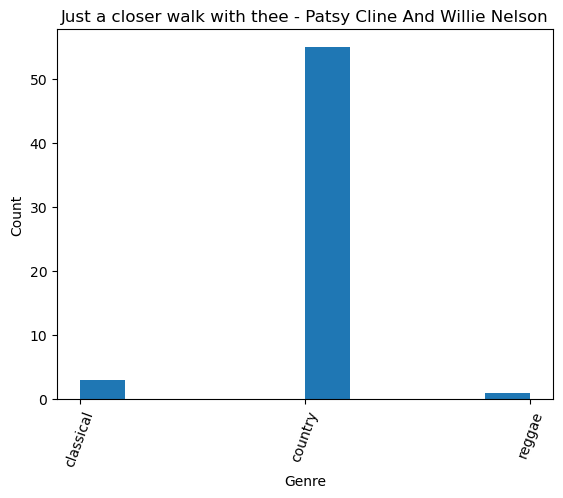

In [58]:
plot_genre_hist(predicted, "Just a closer walk with thee - Patsy Cline And Willie Nelson",y_label="Parition Count")

### Pop music

In [59]:
audio_data = "data/youtube/Dua Lipa - New Rules (Official Music Video).wav"
y, sampling_rate = librosa.load(audio_data)

In [60]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

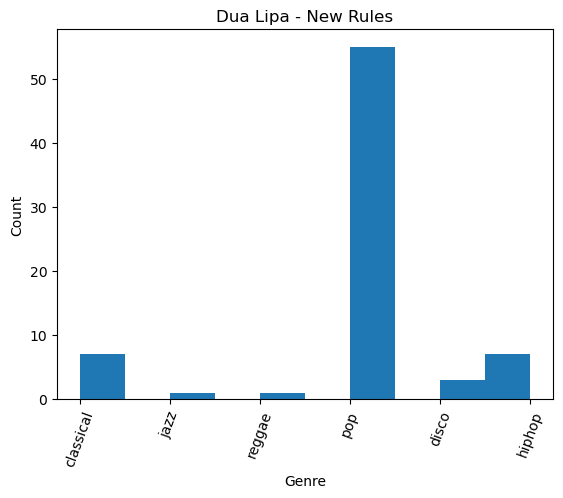

In [61]:
plot_genre_hist(predicted, "Dua Lipa - New Rules",y_label="Parition Count")

In [62]:
audio_data = "data/youtube/Christina Aguilera - Genie In A Bottle (Official Video).wav"
y, sampling_rate = librosa.load(audio_data)

In [63]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

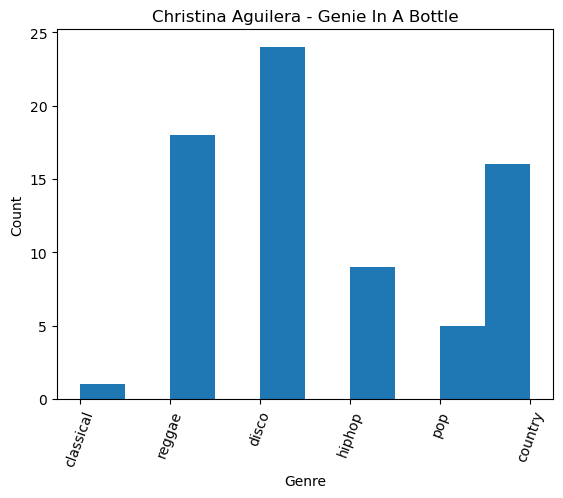

In [64]:
plot_genre_hist(predicted, "Christina Aguilera - Genie In A Bottle",y_label="Parition Count")

The song "Genie In A Bottle" is definitely pop, to some extent it could be classified as disco. Unfortunately it is far away from country or reggae.

### Disco music

In [65]:
audio_data = "data/youtube/Sandra - Maria Magdalena (Official Video 1985).wav"
y, sampling_rate = librosa.load(audio_data)

In [66]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

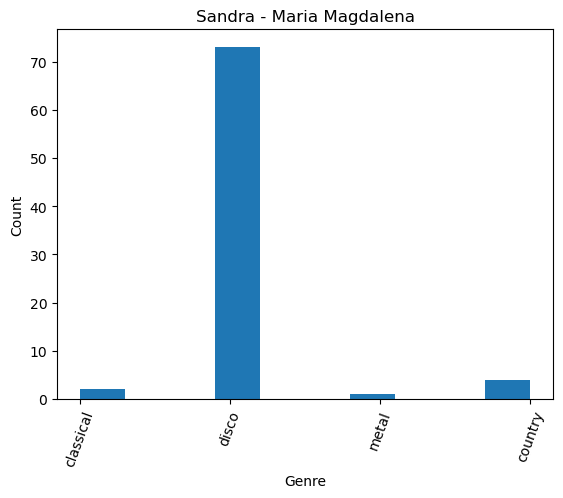

In [67]:
plot_genre_hist(predicted, "Sandra - Maria Magdalena",y_label="Parition Count")

In [68]:
audio_data = "data/youtube/Bee Gees - Stayin' Alive (Official Music Video).wav"
y, sampling_rate = librosa.load(audio_data)

In [69]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

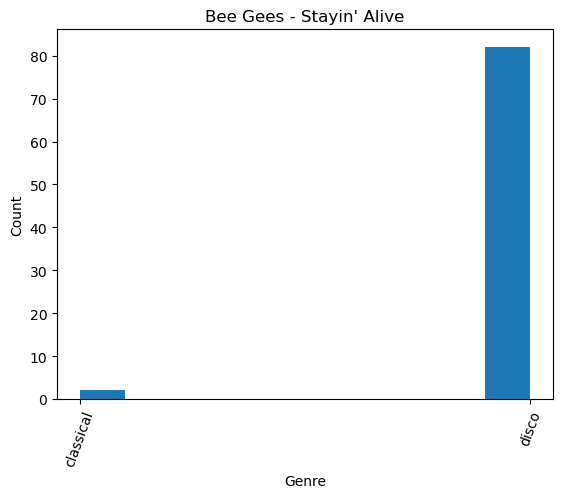

In [70]:
plot_genre_hist(predicted, "Bee Gees - Stayin' Alive",y_label="Parition Count")

### Blues Music

In [71]:
audio_data = "data/youtube/Still Got The Blues.wav"
y, sampling_rate = librosa.load(audio_data)

In [72]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

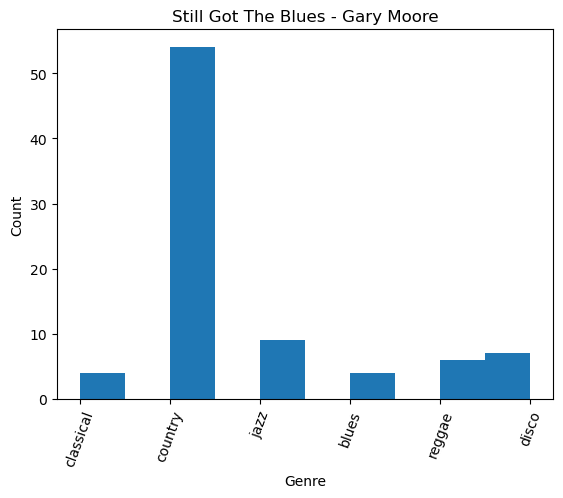

In [73]:
plot_genre_hist(predicted, "Still Got The Blues - Gary Moore",y_label="Parition Count")

Again it is not correct, interestingly Gary More is classified as country. This can be explained with the country ballad songs available in the data set with close sounding. It is misclassified, but we saw in the K-Means Clustering that there is close proximity between these two genres.

In [74]:
audio_data = "data/youtube/B.B. King - The Thrill Is Gone ( 1969 ) HD.wav"
y, sampling_rate = librosa.load(audio_data)

In [75]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

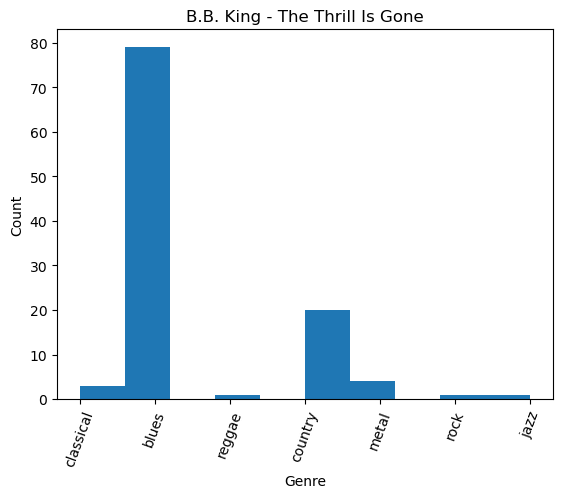

In [76]:
plot_genre_hist(predicted, "B.B. King - The Thrill Is Gone",y_label="Parition Count")

### Rock Music

In [77]:
audio_data = "data/youtube/Lynyrd Skynyrd - Sweet Home Alabama (Lyric Video).wav"
y, sampling_rate = librosa.load(audio_data)

In [78]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

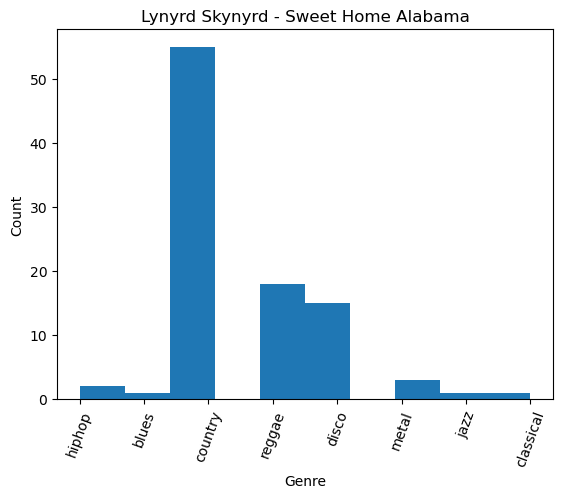

In [79]:
plot_genre_hist(predicted, "Lynyrd Skynyrd - Sweet Home Alabama",y_label="Parition Count")

In [80]:
audio_data = "data/youtube/Bill Haley & His Comets - Rock Around The Clock (1955) HD.wav"
y, sampling_rate = librosa.load(audio_data)

In [81]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

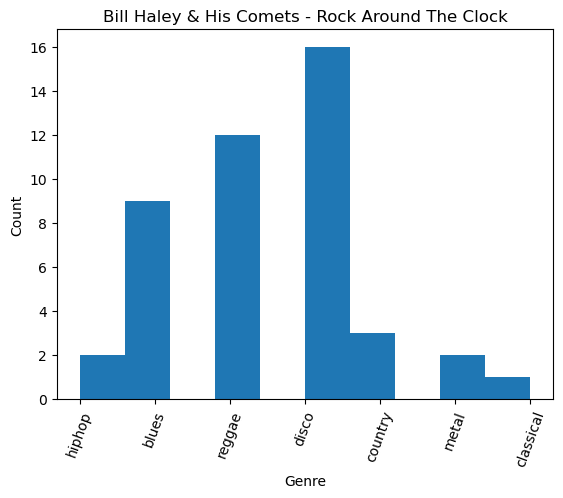

In [82]:
plot_genre_hist(predicted, "Bill Haley & His Comets - Rock Around The Clock",y_label="Parition Count")

As expected the our model preforms poor when it comes to predict rock songs. A possible explanation is that our dataset has very few rock songs and the overall quality of the samples is poor. We do not have enough information to classify correctly rock songs. But this was expected.

### Metal Music

In [83]:
audio_data = "data/youtube/Seek & Destroy (Remastered).wav"
y, sampling_rate = librosa.load(audio_data)

In [84]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

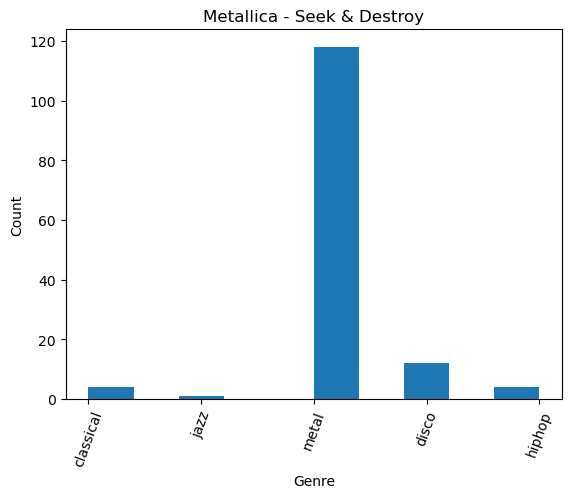

In [85]:
plot_genre_hist(predicted, "Metallica - Seek & Destroy",y_label="Parition Count")

In [86]:
audio_data = "data/youtube/Iron Maiden - Aces High (1998 Remastered Version) #01.wav"
y, sampling_rate = librosa.load(audio_data)

In [87]:
predicted = predic_genre(y, sampling_rate, model, genre_encoder)

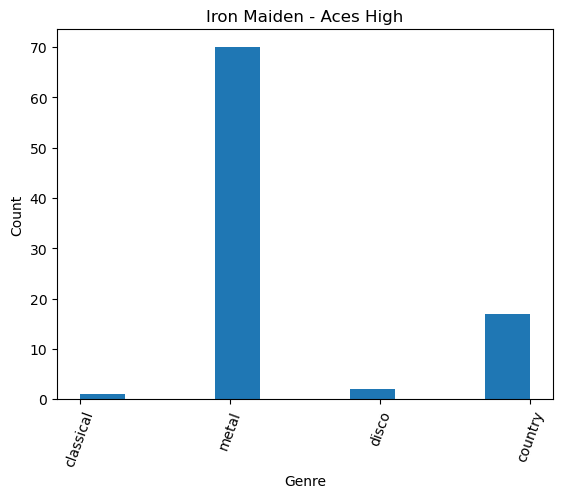

In [88]:
plot_genre_hist(predicted, "Iron Maiden - Aces High",y_label="Parition Count")